Evaluation (for TFIDF-RF)

Load the validation datasets

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime
import pickle

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

In [2]:
import sys

# setting path for common utils script
sys.path.append('../')

import str_cleaning_functions
import dataset_loader

import evaluation_functions


SAVE_EVAL_RESULTS = False
SAVE_NUMPY_ARRAYS = False
LOAD_NUMPY_ARRAYS = True

In [3]:
# import importlib
# importlib.reload(evaluation_functions)

In [4]:
DATASET_SIZE = 480          # change to load different model
DATASET_IS_BALANCED = False  # change to load different model


MAX_FEATURES = 20000        # max_features params for CountVectorizer

training_name = 'tfidf-rf-{}_{}k_{}'.format(
    MAX_FEATURES,
    DATASET_SIZE,
    'bal' if DATASET_IS_BALANCED else 'imbal'
)

training_args_datetime = datetime(year=2023, month=12, day=20)
training_storing_folder = Path(training_name).resolve()

In [5]:
# rerun this cell if want to evaluate a new model

X_train, X_test, y_train, y_test = dataset_loader.load_presampled_traintest_dataset(DATASET_SIZE, DATASET_IS_BALANCED)

Loaded dataset size: 480k, is_balanced: False

Training dataset class distribution
review_score
1    360011
0     71989
Name: count, dtype: int64
Testing dataset class distribution
review_score
1    39989
0     8011
Name: count, dtype: int64





In [6]:
# load validation dataset. Same for all models

X_imbal_valid, y_imbal_valid, X_bal_valid, y_bal_valid = dataset_loader.load_validation_dataset()

Loaded validation dataset

Validation dataset imbalanced class distribution
review_score
1    774377
0    150928
Name: count, dtype: int64
Validation dataset balanced class distribution
review_score
0    150672
1    150672
Name: count, dtype: int64





In [7]:
# data cleaning function

def cleaning_arr(str_arr):
    '''apply all cleaning functions to a numpy array, or a pandas series object'''
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.clean(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.deEmojify(x))
    str_arr = str_arr.apply(lambda x: x.lower())
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_num(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_symbols(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_punctuation(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_stopword(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.unify_whitespaces(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.stemming(x))

    return str_arr

In [8]:
# rerun this cell if loaded a different train/test set

X_train = cleaning_arr(X_train)
X_test = cleaning_arr(X_test)

# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()

KeyboardInterrupt: 

In [ ]:
X_imbal_valid = cleaning_arr(X_imbal_valid)
X_bal_valid = cleaning_arr(X_bal_valid)

# X_bal_valid = X_bal_valid.to_numpy()
# y_bal_valid = y_bal_valid.to_numpy()

# X_imbal_valid = X_imbal_valid.to_numpy()
# y_imbal_valid = y_imbal_valid.to_numpy()

In [9]:
print('Validation (imbalanced) set')
print(len(X_imbal_valid))
print(len(y_imbal_valid))
print()
print('Validation (balanced) set')
print(len(X_bal_valid))
print(len(y_bal_valid))

print()
print()

print('Validation (imbalanced) set')
print(pd.Series(y_imbal_valid).value_counts())
print()
print('Validation (balanced) set')
print(pd.Series(y_bal_valid).value_counts())

print()
print()

print('validation (imbalanced) set datatype')
print(type(X_imbal_valid))
print(type(y_imbal_valid))
print()
print('validation (balanced) set datatype')
print(type(X_bal_valid))
print(type(y_bal_valid))

Validation (imbalanced) set
925305
925305

Validation (balanced) set
301344
301344


Validation (imbalanced) set
review_score
1    774377
0    150928
Name: count, dtype: int64

Validation (balanced) set
review_score
0    150672
1    150672
Name: count, dtype: int64


validation (imbalanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>

validation (balanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


---

Load the models

Rerun all cells below if loading a new model

In [10]:
from datetime import datetime
import pickle

rf_model_path = Path.joinpath(training_storing_folder, "{}_{}_model.sav".format(
    training_name,
    training_args_datetime.strftime("%Y-%m-%d")
))
model = pickle.load(open(rf_model_path, 'rb'))

count_vectorizer_path = Path.joinpath(training_storing_folder, "{}_{}_count_vectorizer.pkl".format(
    training_name,
    training_args_datetime.strftime("%Y-%m-%d")
))
vectorizer = pickle.load(open(count_vectorizer_path, 'rb'))

tfidf_transformer_path = Path.joinpath(training_storing_folder, "{}_{}_tfidf.pkl".format(
    training_name,
    training_args_datetime.strftime("%Y-%m-%d")
))
tfidf = pickle.load(open(tfidf_transformer_path, 'rb'))

print('Loaded model from {}'.format(rf_model_path))
print('Loaded count vectorizer from {}'.format(count_vectorizer_path))
print('Loaded tfidf transformer from {}'.format(tfidf_transformer_path))

Loaded model from /Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal/tfidf-rf-20000_480k_imbal_2023-12-20_model.sav
Loaded count vectorizer from /Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal/tfidf-rf-20000_480k_imbal_2023-12-20_count_vectorizer.pkl
Loaded tfidf transformer from /Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal/tfidf-rf-20000_480k_imbal_2023-12-20_tfidf.pkl


---

Evaluation

In [11]:
from sklearn.pipeline import Pipeline

pipeline_test = Pipeline([
    ('vect', vectorizer),
    ('tfidf', tfidf),
    ('model', model),
])

In [12]:
# create folders for storing evaluation metrics

eval_metrics_folder = Path.joinpath(training_storing_folder, 'eval_metrics')

if not eval_metrics_folder.exists():
    eval_metrics_folder.mkdir()

eval_test_prefix = 'test'
eval_valid_bal_prefix = 'valid_bal'
eval_valid_imbal_prefix = 'valid_imbal'

eval_test_folder = Path.joinpath(eval_metrics_folder, eval_test_prefix)
eval_valid_bal_folder = Path.joinpath(eval_metrics_folder, eval_valid_bal_prefix)
eval_valid_imbal_folder = Path.joinpath(eval_metrics_folder, eval_valid_imbal_prefix)

if not eval_test_folder.exists():
    eval_test_folder.mkdir()

if not eval_valid_bal_folder.exists():
    eval_valid_bal_folder.mkdir()

if not eval_valid_imbal_folder.exists():
    eval_valid_imbal_folder.mkdir()

print('Folders for storing evaluation metrics')
print(eval_test_folder)
print(eval_valid_bal_folder)
print(eval_valid_imbal_folder)

Folders for storing evaluation metrics
/Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal/eval_metrics/test
/Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal/eval_metrics/valid_bal
/Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/tfidf-rf_2023-12-16/tfidf-rf-20000_480k_imbal/eval_metrics/valid_imbal


on test set

In [19]:
if LOAD_NUMPY_ARRAYS:
    y_test_pred_prob_raw = np.load(Path.joinpath(eval_test_folder, 'y_test_pred_prob_raw.npy'))
    y_test_pred = np.load(Path.joinpath(eval_test_folder, 'y_test_pred.npy'))
    y_test_pred_prob = np.load(Path.joinpath(eval_test_folder, 'y_test_pred_prob.npy'))
    y_test = np.load(Path.joinpath(eval_test_folder, 'y_test.npy'))
else:
    y_test_pred_prob_raw = pipeline_test.predict_proba(X_test)

    y_test_pred = np.argmax(y_test_pred_prob_raw, axis=1)

    y_test_pred_prob = y_test_pred_prob_raw if len(np.unique(y_test_pred)) > 2 \
                    else np.array([y_test_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_test_pred))])

In [14]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_test_folder, 'y_test_pred_prob_raw.npy'), y_test_pred_prob_raw)
    np.save(Path.joinpath(eval_test_folder, 'y_test_pred.npy'), y_test_pred)
    np.save(Path.joinpath(eval_test_folder, 'y_test_pred_prob.npy'), y_test_pred_prob)
    np.save(Path.joinpath(eval_test_folder, 'y_test.npy'), y_test)

In [15]:
test_classification_report_dict = evaluation_functions.print_classification_report(y_test, y_test_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.81      0.31      0.45      8011
           1       0.88      0.99      0.93     39989

    accuracy                           0.87     48000
   macro avg       0.84      0.65      0.69     48000
weighted avg       0.87      0.87      0.85     48000



TN - True Negative 2507
FN - False Negative 584
TP - True Positive 39405
FP - False Positive 5504
Accuracy Rate: 0.8731666666666666
Misclassification Rate: 0.12683333333333333
F1-Score: 0.6899603779836917
ROC-AUC 0.6491703424658233


In [16]:
test_classification_report_dict

{'0': {'precision': 0.8110643804593982,
  'recall': 0.3129447010360754,
  'f1-score': 0.4516303368762386,
  'support': 8011.0},
 '1': {'precision': 0.8774410474515131,
  'recall': 0.9853959838955713,
  'f1-score': 0.9282904190911447,
  'support': 39989.0},
 'accuracy': 0.8731666666666666,
 'macro avg': {'precision': 0.8442527139554556,
  'recall': 0.6491703424658233,
  'f1-score': 0.6899603779836917,
  'support': 48000.0},
 'weighted avg': {'precision': 0.866363058299975,
  'recall': 0.8731666666666666,
  'f1-score': 0.8487378374531528,
  'support': 48000.0}}

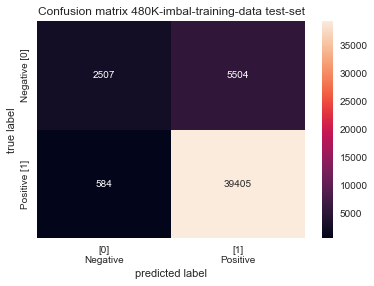

In [17]:
import matplotlib as plt
# plt.style.use('seaborn-v0_8-dark')
plt.style.use('seaborn-v0_8')

evaluation_functions.create_confusion_matrix_graph(
    y_test,
    y_test_pred,
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_test_folder, f'confusion_matrix_test.png'),
    show=True
)

In [18]:
evaluation_functions.plot_roc_curve_binary(
    y_test,
    y_test_pred_prob,
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_test_folder, f'roc_curve_test.png'),
    show=True
)

/Users/michaelcheng/miniforge3/envs/fyp-test/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:823: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_true = y_true == pos_label


TypeError: 'bool' object is not subscriptable

In [ ]:
from sklearn.metrics import roc_auc_score

# import importlib
# importlib.reload(evaluation_functions)

# add ROC area to report_dict
test_classification_report_dict['roc_auc'] = roc_auc_score(y_test, y_test_pred_prob)

test_report_df = evaluation_functions.create_classification_report_df(
    test_classification_report_dict, 
    training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    test_report_df.to_csv(Path.joinpath(eval_test_folder, "{}_{}_test_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

on fixed balanced validation set

In [ ]:
if LOAD_NUMPY_ARRAYS:
    y_bal_valid_pred_prob_raw = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob_raw.npy'))
    y_bal_valid_pred = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred.npy'))
    y_bal_valid_pred_prob = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob.npy'))
    y_bal_valid = np.load(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid.npy'))
else:
    y_bal_valid_pred_prob_raw = pipeline_test.predict_proba(X_bal_valid)

    y_bal_valid_pred = np.argmax(y_bal_valid_pred_prob_raw, axis=1)

    y_bal_valid_pred_prob = y_bal_valid_pred_prob_raw if len(np.unique(y_bal_valid_pred)) > 2 \
                    else np.array([y_bal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_bal_valid_pred))])

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:    9.2s


In [ ]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob_raw.npy'), y_bal_valid_pred_prob_raw)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred.npy'), y_bal_valid_pred)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid_pred_prob.npy'), y_bal_valid_pred_prob)
    np.save(Path.joinpath(eval_valid_bal_folder, 'y_bal_valid.npy'), y_bal_valid)

In [ ]:
bal_valid_classification_result_dict = evaluation_functions.print_classification_report(y_bal_valid, y_bal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.96      0.32      0.48    150672
           1       0.59      0.99      0.74    150672

    accuracy                           0.65    301344
   macro avg       0.77      0.65      0.61    301344
weighted avg       0.77      0.65      0.61    301344



TN - True Negative 47995
FN - False Negative 2173
TP - True Positive 148499
FP - False Positive 102677
Accuracy Rate: 0.6520587766804715
Misclassification Rate: 0.34794122331952854
F1-Score: 0.6085115446184535
ROC-AUC 0.6520587766804715


In [ ]:
bal_valid_classification_result_dict

{'0': {'precision': 0.9566855365970339,
  'recall': 0.31853960921737284,
  'f1-score': 0.4779426409081856,
  'support': 150672.0},
 '1': {'precision': 0.5912149249928337,
  'recall': 0.9855779441435701,
  'f1-score': 0.7390804483287212,
  'support': 150672.0},
 'accuracy': 0.6520587766804715,
 'macro avg': {'precision': 0.7739502307949337,
  'recall': 0.6520587766804715,
  'f1-score': 0.6085115446184535,
  'support': 301344.0},
 'weighted avg': {'precision': 0.7739502307949337,
  'recall': 0.6520587766804715,
  'f1-score': 0.6085115446184534,
  'support': 301344.0}}

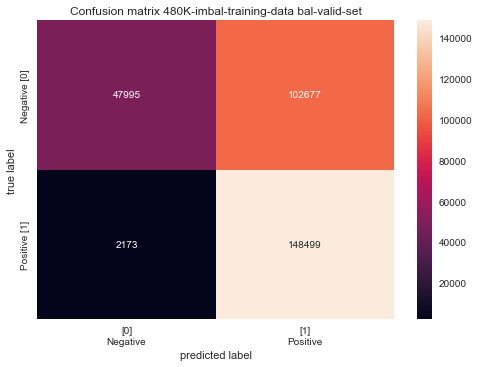

In [ ]:
evaluation_functions.create_confusion_matrix_graph(
    y_bal_valid, y_bal_valid_pred, 
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_bal_folder, f'confusion_matrix_valid_bal.png'),
    show=True
)

0.8744315885966406


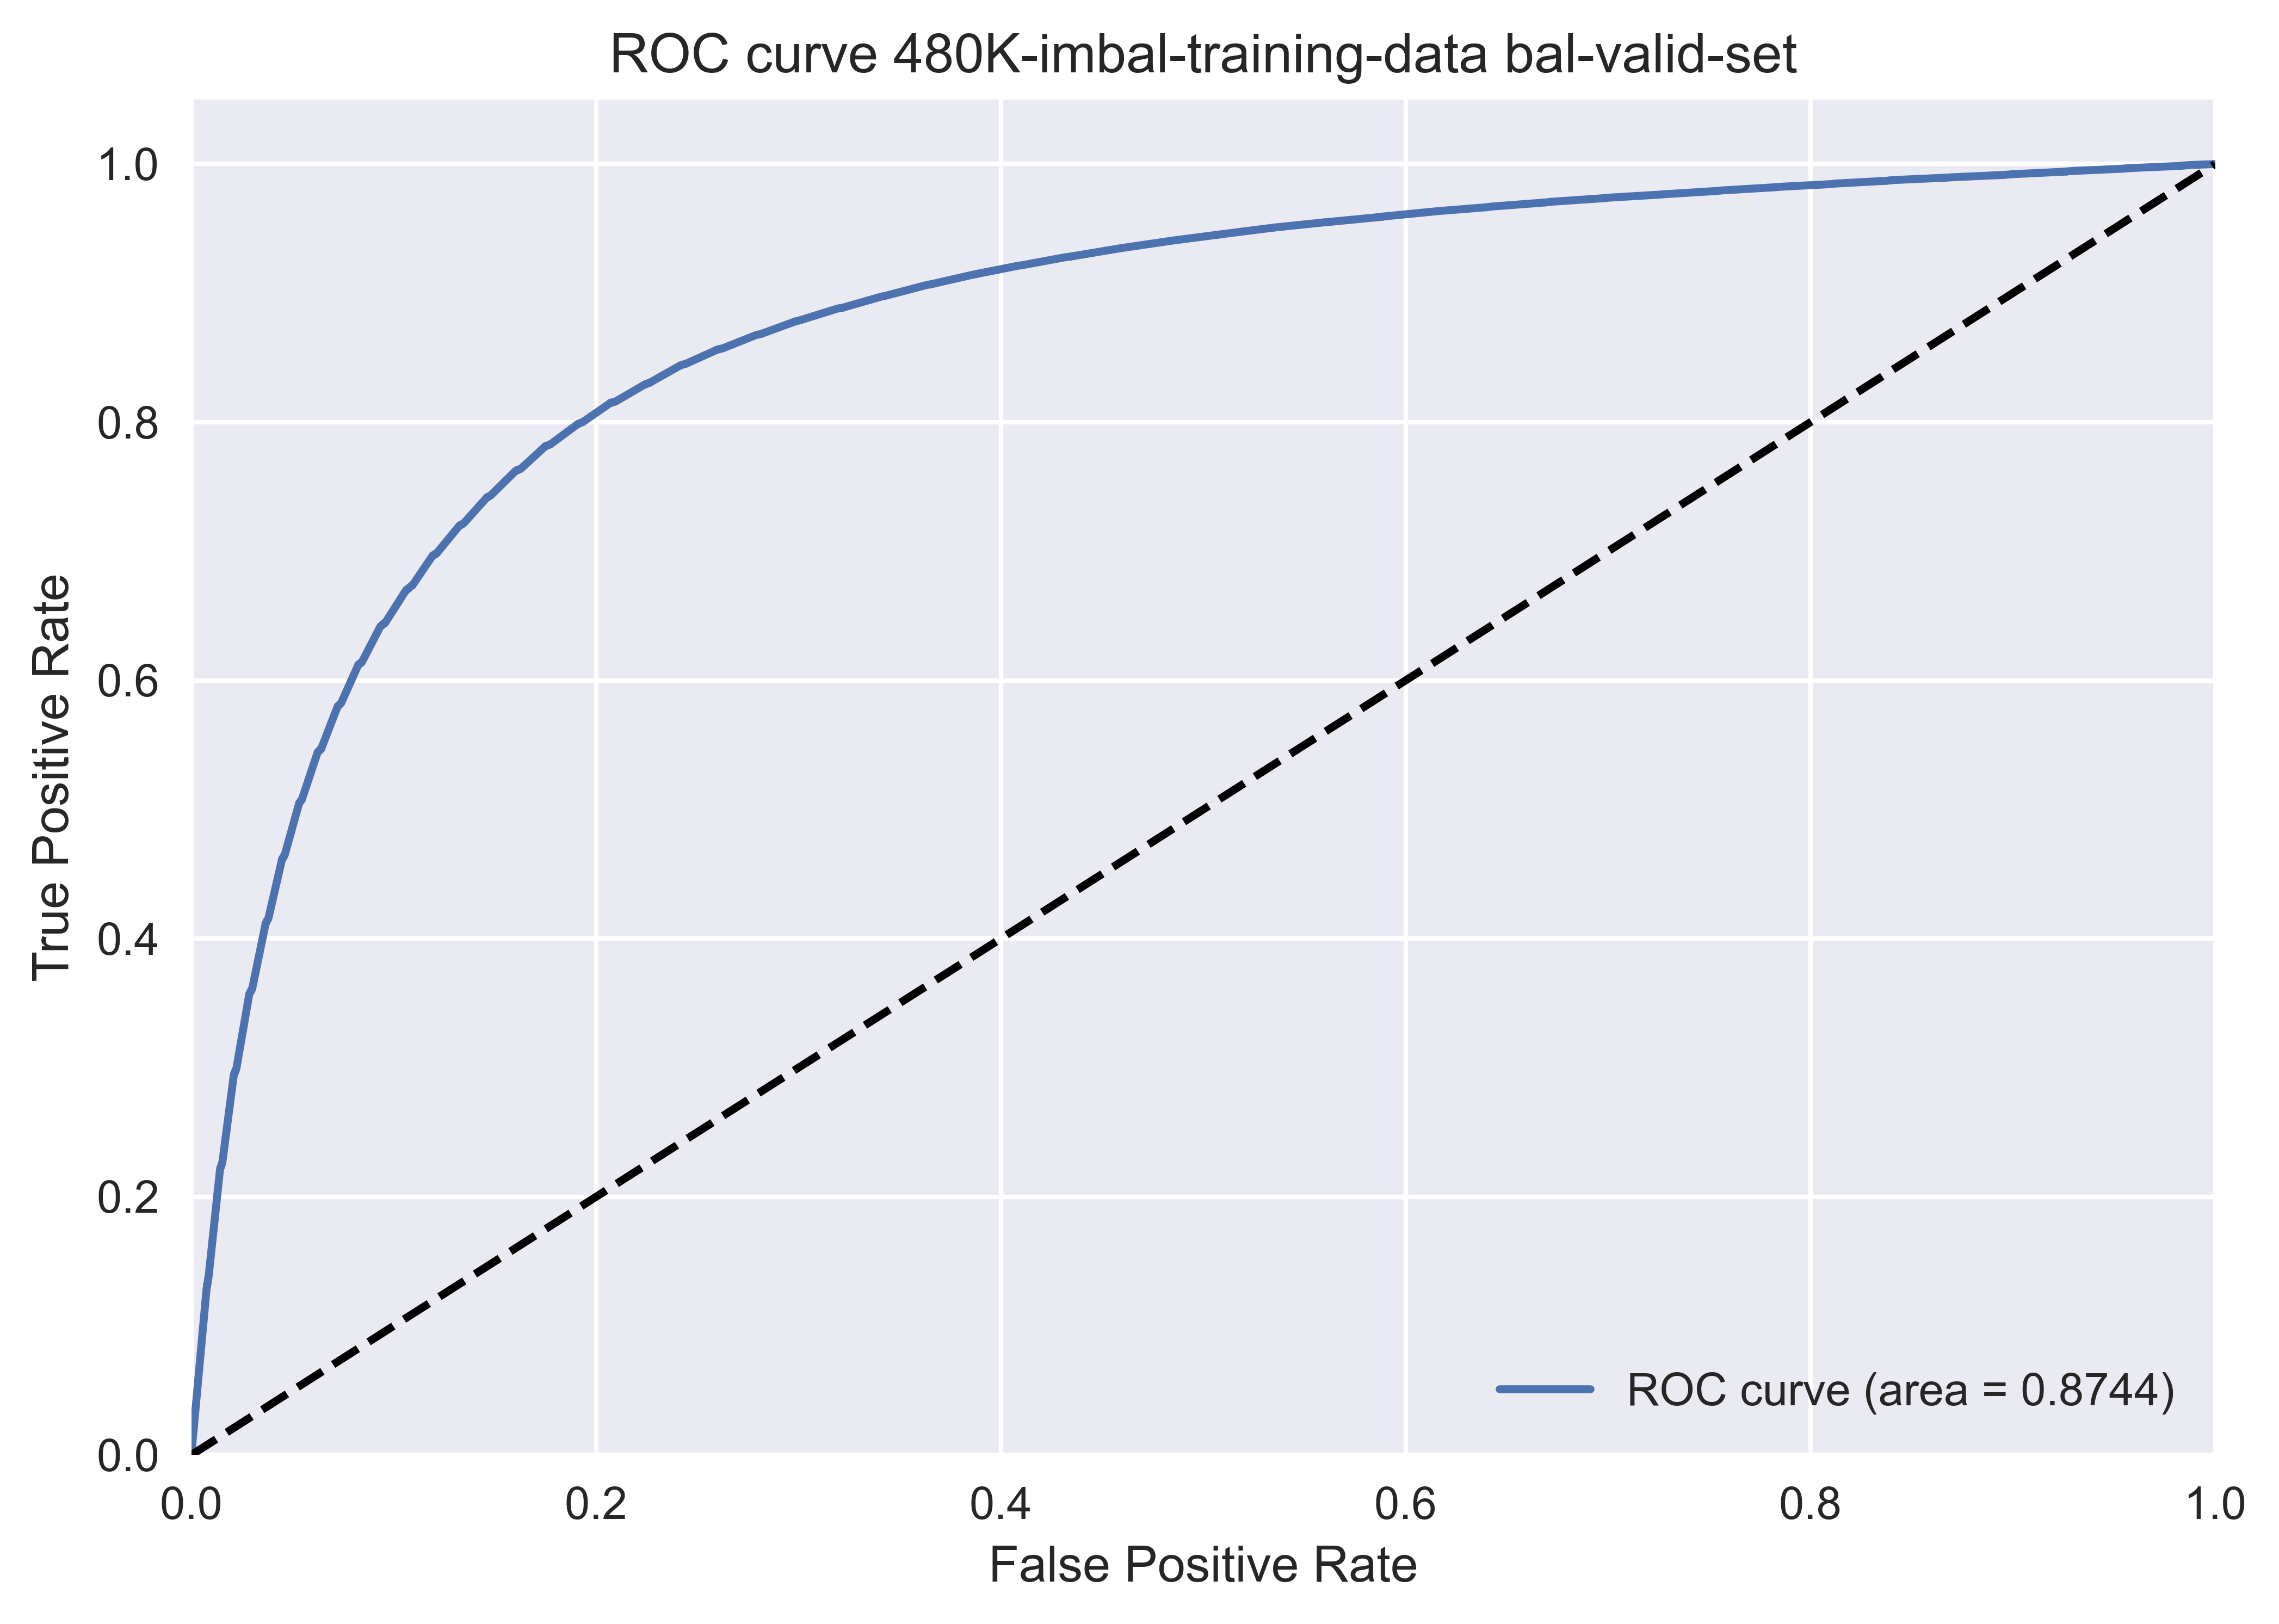

In [ ]:
evaluation_functions.plot_roc_curve_binary(
    y_bal_valid, y_bal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set', 
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_bal_folder, f'roc_curve_valid_bal.png'),
    show=True
)

In [ ]:
# add ROC area to report_dict
bal_valid_classification_result_dict['roc_auc'] = roc_auc_score(y_bal_valid, y_bal_valid_pred_prob)

bal_valid_report_df = evaluation_functions.create_classification_report_df(bal_valid_classification_result_dict, training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    bal_valid_report_df.to_csv(Path.joinpath(eval_valid_bal_folder, "{}_{}_valid_bal_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

on fixed validation set (imbalanced)

In [ ]:
if LOAD_NUMPY_ARRAYS:
    y_imbal_valid_pred_prob_raw = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob_raw.npy'))
    y_imbal_valid_pred = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred.npy'))
    y_imbal_valid_pred_prob = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob.npy'))
    y_imbal_valid = np.load(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid.npy'))
else:
    y_imbal_valid_pred_prob_raw = pipeline_test.predict_proba(X_imbal_valid)

    y_imbal_valid_pred = np.argmax(y_imbal_valid_pred_prob_raw, axis=1)

    y_imbal_valid_pred_prob = y_imbal_valid_pred_prob_raw if len(np.unique(y_imbal_valid_pred)) > 2 \
                    else np.array([y_imbal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_imbal_valid_pred))])

[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:   31.6s


In [ ]:
if SAVE_NUMPY_ARRAYS:
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob_raw.npy'), y_imbal_valid_pred_prob_raw)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred.npy'), y_imbal_valid_pred)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid_pred_prob.npy'), y_imbal_valid_pred_prob)
    np.save(Path.joinpath(eval_valid_imbal_folder, 'y_imbal_valid.npy'), y_imbal_valid)

In [ ]:
imbal_valid_classification_result_dict = evaluation_functions.print_classification_report(y_imbal_valid, y_imbal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.32      0.46    150928
           1       0.88      0.99      0.93    774377

    accuracy                           0.88    925305
   macro avg       0.85      0.65      0.69    925305
weighted avg       0.87      0.88      0.85    925305



TN - True Negative 48070
FN - False Negative 10796
TP - True Positive 763581
FP - False Positive 102858
Accuracy Rate: 0.877171311081211
Misclassification Rate: 0.12282868891878894
F1-Score: 0.6944961495208972
ROC-AUC 0.6522773534222301


In [ ]:
imbal_valid_classification_result_dict

{'0': {'precision': 0.8166004145007305,
  'recall': 0.31849623661613485,
  'f1-score': 0.45825905411975554,
  'support': 150928.0},
 '1': {'precision': 0.8812865071863109,
  'recall': 0.9860584702283255,
  'f1-score': 0.9307332449220388,
  'support': 774377.0},
 'accuracy': 0.877171311081211,
 'macro avg': {'precision': 0.8489434608435207,
  'recall': 0.6522773534222301,
  'f1-score': 0.6944961495208972,
  'support': 925305.0},
 'weighted avg': {'precision': 0.870735453645209,
  'recall': 0.877171311081211,
  'f1-score': 0.853667212998071,
  'support': 925305.0}}

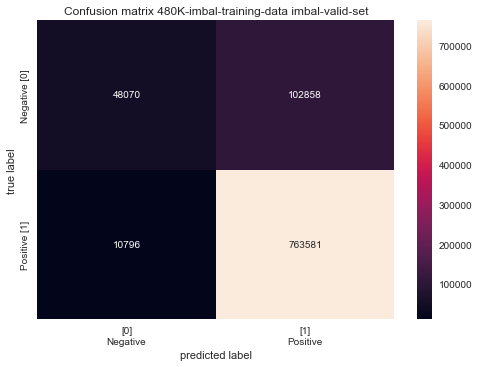

In [ ]:
evaluation_functions.create_confusion_matrix_graph(
    y_imbal_valid, y_imbal_valid_pred, 
    title=f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data imbal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_imbal_folder, f'confusion_matrix_valid_imbal.png'),
    show=True
)

0.8753968836303159


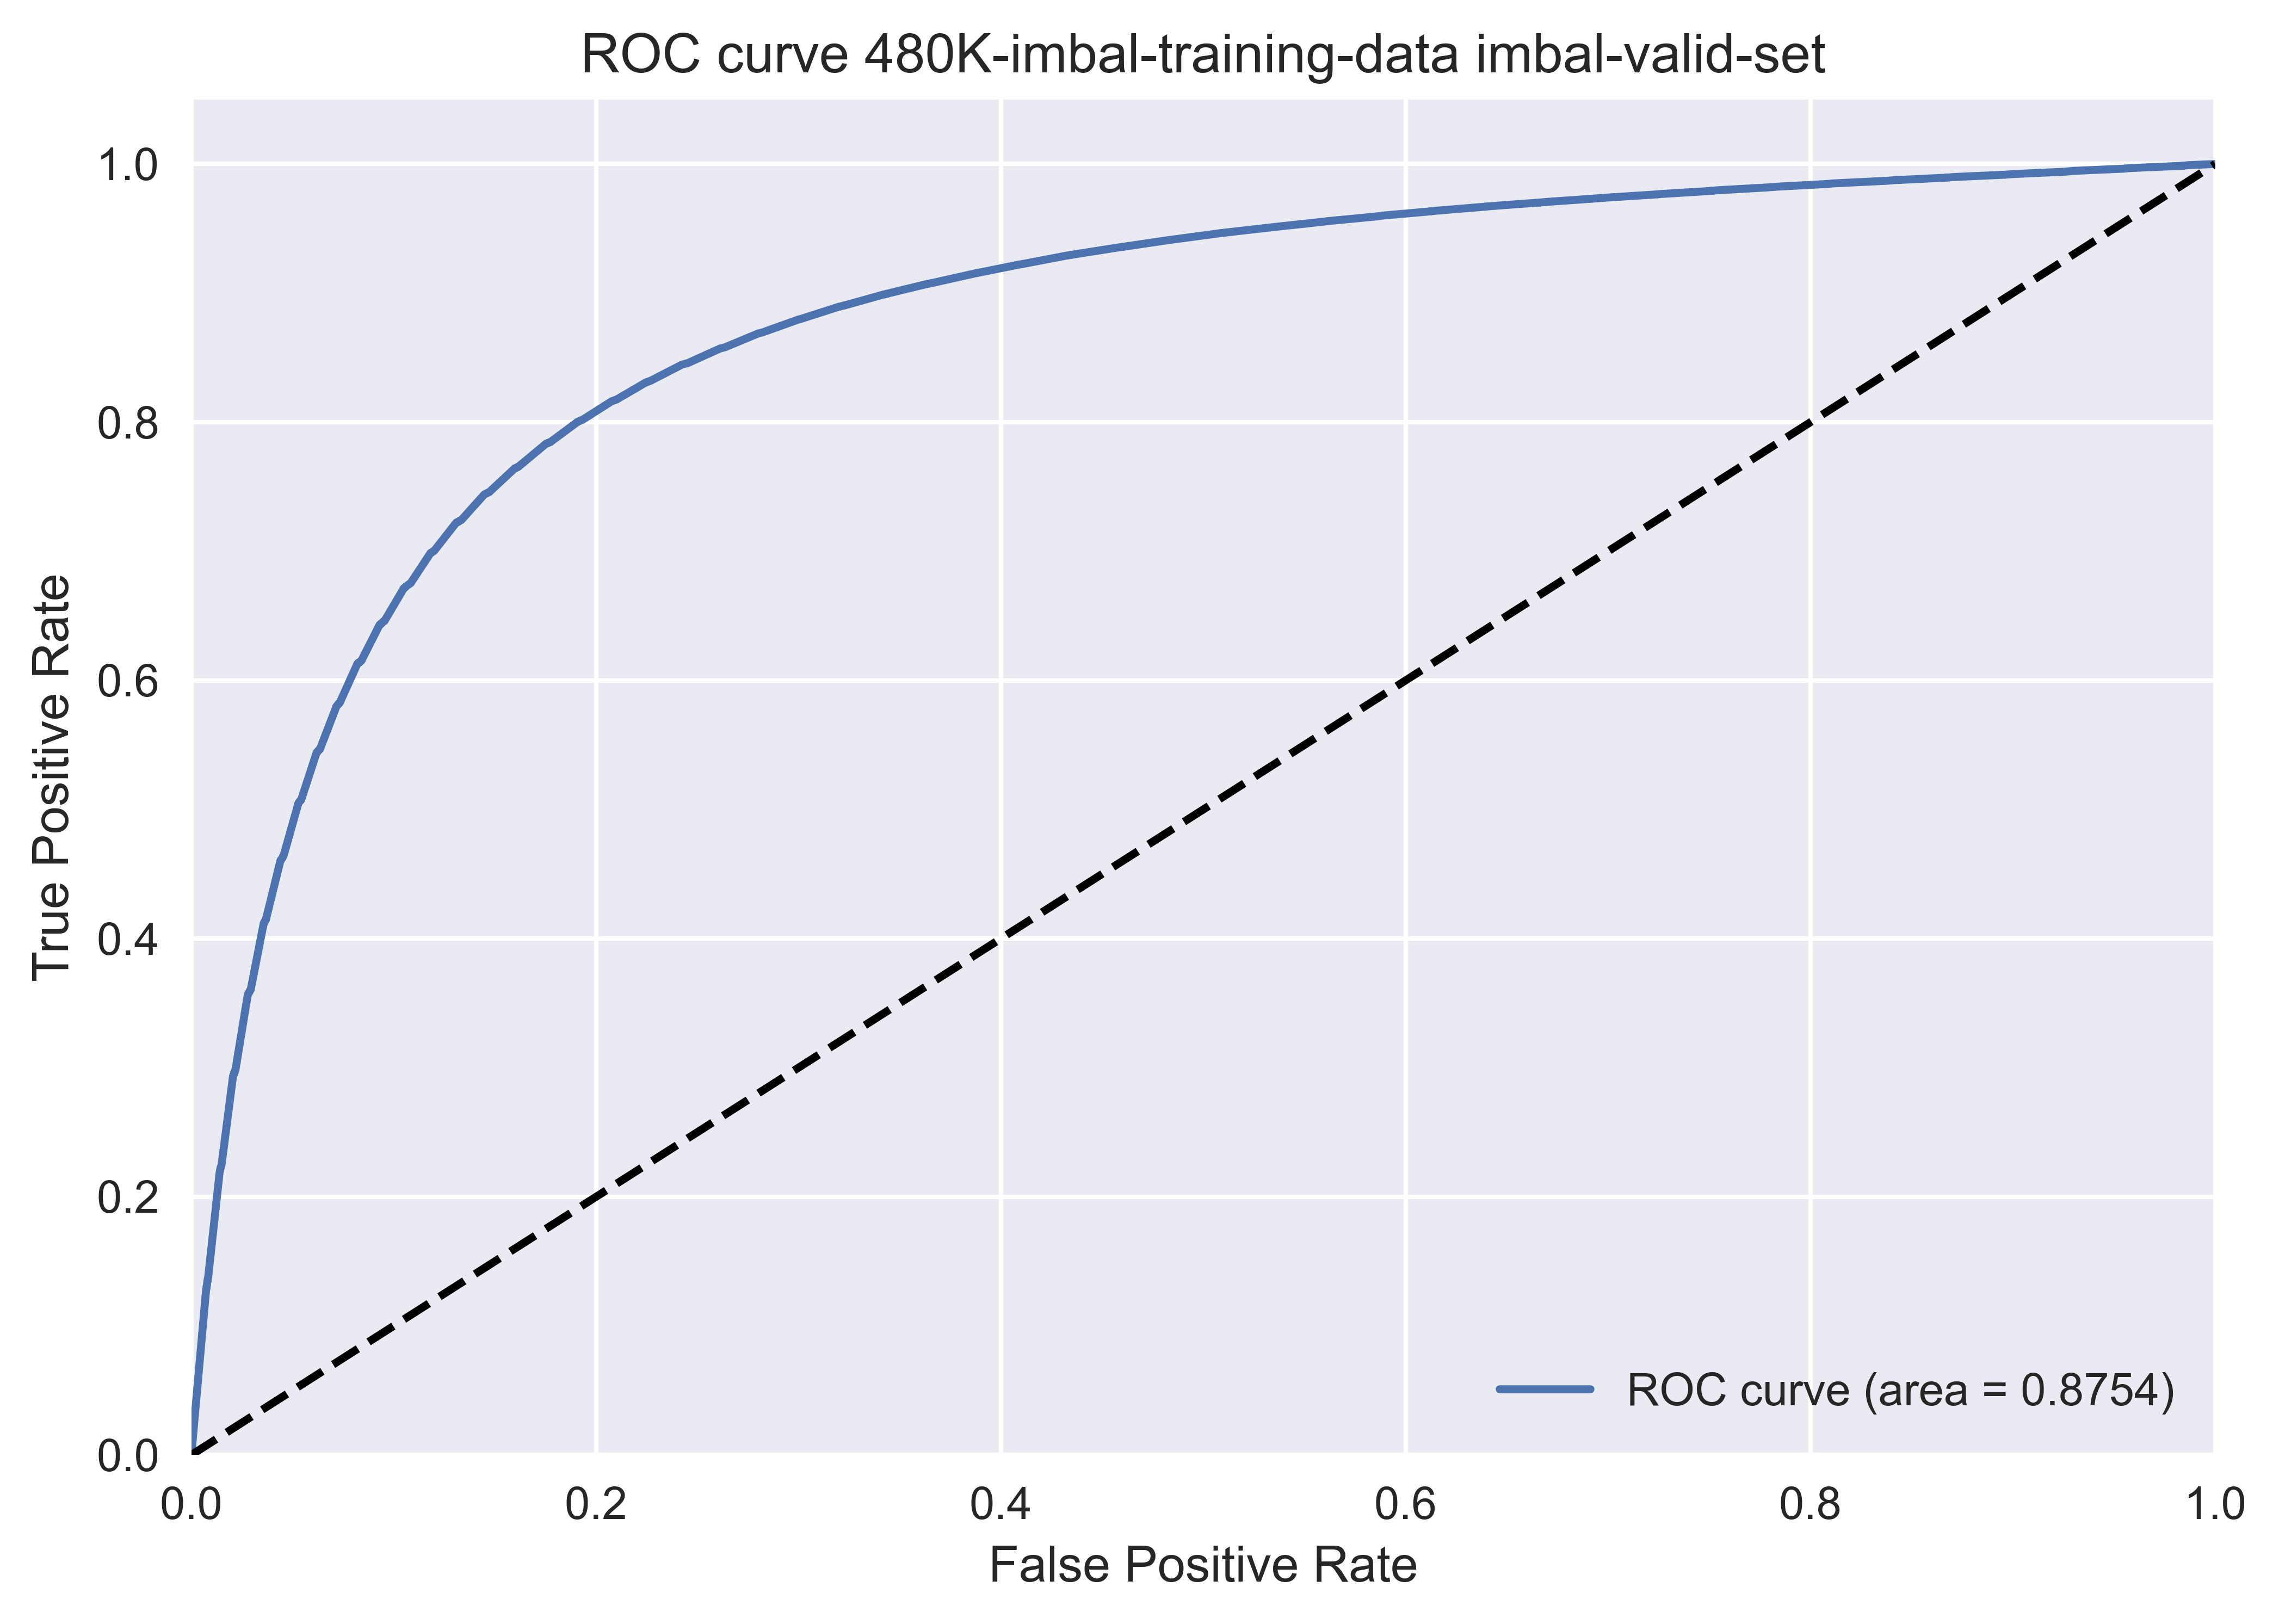

In [ ]:
evaluation_functions.plot_roc_curve_binary(
    y_imbal_valid, y_imbal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data imbal-valid-set',
    save=SAVE_EVAL_RESULTS,
    save_filename=Path.joinpath(eval_valid_imbal_folder, f'roc_curve_valid_imbal.png'),
    show=True
)

In [ ]:
# add ROC area to report_dict
imbal_valid_classification_result_dict['roc_auc'] = roc_auc_score(y_imbal_valid, y_imbal_valid_pred_prob)

imbal_valid_report_df = evaluation_functions.create_classification_report_df(imbal_valid_classification_result_dict, training_name)

# save the dataframe
if SAVE_EVAL_RESULTS:
    imbal_valid_report_df.to_csv(Path.joinpath(eval_valid_imbal_folder, "{}_{}_valid_imbal_report.csv".format(
        training_name,
        training_args_datetime.strftime("%Y-%m-%d")
    )))

Evluation end